本文内容是对 [Hands-on Machine Learning with Scikit-Learn and TensorFlow](http://shop.oreilly.com/product/0636920052289.do) 这本书的第三章的实践，这一章讲了在分类任务中，评估分类效果的种种策略。

## 下载数据集

首先先下载数据集。sklearn 通过网络下速度极慢，可以手动去其他地方（比如[这里](https://raw.githubusercontent.com/amplab/datascience-sp14/master/lab7/mldata/mnist-original.mat)）下载对应文件，然后放到 `~/$HOME/scikit_learn_data/mldata/` 目录下。

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.datasets import fetch_mldata

# https://raw.githubusercontent.com/amplab/datascience-sp14/master/lab7/mldata/mnist-original.mat
mnist = fetch_mldata('MNIST original')

In [4]:
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [5]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

这个数据集中包含 70000 张手写数字，每张图片的分辨率为 `28*28`。每张图片有一个对应了 label 指出该图片对应的数字。

## 观察样本

随便挑出一些样本进行观察。

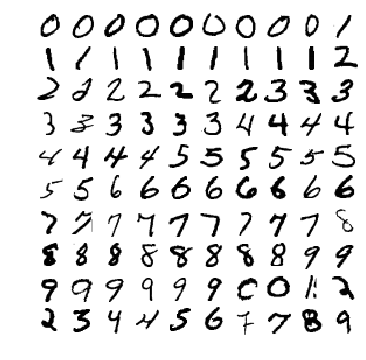

In [6]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(6,6))
example_images = X[0:70000:700]
plot_digits(example_images, images_per_row=10)

## 划分训练集和测试集

这里取了前 6 万个样本做训练集，为了方式对应相同的数字样本连续出现，要将样本打乱。下面的步骤完全可以使用 sklearn 中的 `train_test_split` 来完成。

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 把训练集的顺序打乱，防止同种标签的样本连续出现
shuffle_index = np.random.permutation(60000)
X_train = X_train[shuffle_index]
y_train = y_train[shuffle_index]

## 训练二分类分类器

样本中包含 0~9 共 10 类样本，但此处先训练一个二分类分类器，用来区分 5 和其他数字。

为此需要把标签修改为 0 或 1，0 对应非数字 5， 1 对应数字 5。

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

这里使用 `SGDClassifier` 分类器，`SGDClassifier` 的做法是将样本属性值线性加权求和，当和大于某个阈值时为正例，否则为反例。它在不断迭代中，利用误差采用随机梯度下降的方式更新权重。

使用此分类器，可以设置一个迭代次数，当迭代次数到了后，停止训练，但是往往事先并不知道需要迭代多少次。另一种方法是设置参数 tol，即 tolerance，当两次迭代之间 loss 减少量低于 tol 时训练结束。为了避免迭代次数过多，可以设置 `max_iter` 参数，限制最大迭代次数。

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42, max_iter=500, tol=0.01)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=500,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=0.01,
       validation_fraction=0.1, verbose=0, warm_start=False)

## 测试分类器性能

对分类效果的评估有很多种指标。

### 1. 使用交叉验证来测试性能

在评估机器学习算法的效果时，要用到为参与训练的样本来测试算法的效果。测试数据一般不应该参与到模型的选择中，因为使用测试数据来改进算法导致的结果是，学习到的模型较契合于测试集。
测试数据只应该用于模型确定之后，来估计泛化误差，不应该参与到用于改进模型中。

使用交叉验证，在每次训练中，从原训练集分出训练集和验证集，使用分出来的训练集来训练模型，使用验证集来在分类器上得出分类准确率、召回率等指标。这样在 K 折交叉验证中，能得到 K 组指标，与仅有一组测试指标相比，观察这 K 组指标能够得出更加可信的结论。

为了评估模型的效果，需要从训练集中划分出一个验证集。当数据量很少的时候，训练数据本就很小，划分出的验证集自然也不能很大。在一个小的验证集上得到的结果就显得不那么可靠。k 折交叉验证将数据分为 K 份，每次使用 K-1 份数据作为训练集，使用余下的 1 份作为验证集。这样训练 K 的模型，验证 K 次，最后求出 K 个评估指标的均值，作为最终评估结构。

![<width,400px>](https://wangyu-name.oss-cn-hangzhou.aliyuncs.com/superbed/2019/05/07/5cd0f9253a213b0417e34cf2.jpg)

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

acc_list = []
kf = KFold(n_splits=4)

for train_index, val_index in kf.split(X_train):
    partial_X_train = X_train[train_index]
    partial_y_train = y_train_5[train_index]

    X_val = X_train[val_index]
    y_val = y_train_5[val_index]
    
    sgd_clf = SGDClassifier(random_state=42, max_iter=500, tol=0.01)
    sgd_clf.fit(partial_X_train, partial_y_train)
    
    y_pred = sgd_clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    
    acc_list.append(acc)
    
print(acc_list)

[0.9642666666666667, 0.9664666666666667, 0.963, 0.9132]


实际项目中，可以使用 sklearn 中的 `cross_val_score` 来进行交叉验证，比起自己实现 K 折交叉验证，此函数还可以多进程执行。

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=4, scoring="accuracy", n_jobs=-1)

array([0.95700287, 0.96053333, 0.96806667, 0.95273018])

准确度 (accuracy)，表示在所有样本中，被预测正确的样本的占比。这里 accuracy 达到了 97% 左右，看似很喜人的结果，但事实并非如此。

因为样本中正例（数字5）和反例（非数字5）的比例是 1:9，因此分类器只需要对所有待测样本均输出 0（认为该样本不是数字5），也能得到 90% 的准确度。所以在这个场景下 accuracy，就没有很大的参考意义。
    
accuracy 在分类问题中往往不能很好地体现分类器的性能，尤其是在样本分布不均匀的情况下。

### 2. 使用 confusion matrix

confusion matrix 用来观察分类的具体细节，能够看出各个类别样本都被分到了那些类别，以及占比如何。因此，需要对某些样本进行预测，并与其真实的标签对比。

使用 `cross_val_predict` 可以在交叉验证的每一折中，对验证集进行预测，进而得出对整个训练集的预测。因为在交叉验证中，一部分训练集被抽出来作为验证集，因此交叉验证的每一折，都可以得出部分训练集的预测结果。利用预测结果与训练集真实的样本标签比较，可以得到 confusion matrix。

In [13]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5,  n_jobs=-1)


from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53256,  1323],
       [ 1214,  4207]])

confusion matrix 中第 n 行 m 列的元素，表示第 n 类被预测为第 m 类的数量。因此对角线上的元素越大越好，非对角线上的元素越接近 0 越好。

### 3. 精度和召回率 / precision and recall

这里的精度和前面的 accuracy 不同，**precision** 表示在预测为真的样本中，实际确实为真的样本的占比。因此，如果要提高 precision，可以只对那些有非常大的把握认为是正例的样本预测为正。追求高精度，也就是强调结果的可靠性、准确性。可以漏掉一些正例，但一旦认为某些样本是正例，那就得有很大把握才是。

**召回率**表示预测结果中，预测正确的正例占所有正例的比例。即所有正例中有多少被真真切切地找出来了，指被预测为正的正例占所有正例的比例。为了提高召回率，可以认为所有样本都是正例，这样召回率就为 1，不过此时精度也就下降了，因为有大量不是正例的样本被认为是正例。

```
precision = TP / (TP + FP)

recall = TP / (TP + FN)
```


可以看出，实际项目中在 precision 和 recall 之间需要权衡，两者中一个升高，另一个就要降低。


```
F1 = 2 * precision * recall / (precision + recall)
```

F1 是 precision 和 recall 的调和平均数，F1 指标将 precision 和 recall 综合起来，只有 precision 和 recall 都具有较大的值时，F1 的值才会大。

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score

(
    precision_score(y_train_5, y_train_pred),
    recall_score(y_train_5, y_train_pred),
    f1_score(y_train_5, y_train_pred)
)

(0.760759493670886, 0.7760560782143516, 0.7683316592092047)

### 4. precision and recall 曲线

某些时候，希望预测结果能有较高的 precision 或者 recall，这需要改变分类器给样本分类的策略。通常分类器是根据样本的属性值采用某种策略（比如加权求和）得出一个值（信心指数，confidence scores），当此值大于某个阈值 (threshold) 的时候认为样本是正例，否则认为是反例。要想提高 precision 或者 recall 中的某一个指标，只需要调整这个阈值即可。

比如提高 threshold 意味着当分类器十分确信的时候，才会将样本分为正例，如此就能提高 precision。相反，降低 threshold 就能够提高 recall。

要设置这个 threshold 需要知道相应的 threshold 的各个值下对应的 precision 和 recall 分别为多少。一个方法是让分类器返回对各个样本的 confidence scores，拿一个 threshold 和各个样本的 confidence scores 比较，就能得出此 threshold 下的 precision 和 recall。如此不断调大 threshold 就可以知道各个 threshold 对应的 precision 和 recall 了。

通过调用分类器上的 `decision_function` 方法可以返回各个样本的 `confidence scores`：

In [15]:
y_scores = sgd_clf.decision_function(X_train[0:10])
y_scores

array([-24932.63544288, -21166.8907727 , -18782.37112855, -10649.15697538,
       -12859.27399089, -34093.24186857, -20045.6491261 , -13236.36453865,
       -16931.29933201, -19374.46421172])

可以使用交叉验证来对训练集中各个样本得出 `confidence scores`

前面提到过 `cross_val_predict` 能够用来得出模型对训练集的预测结果，但此时我们不让它输出预测的分类标签，而是让它输出 `confidence scores`。`method` 参数是指在传入的 estimator，即分类器，上调用 `method` 指定的方法，并作为预测结果返回。这里需要得到样本的 `confidence scores` 因此传入 `method="decision_function"`。

In [16]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5, method="decision_function", n_jobs=-1)

利用各个样本的 confidence scores 和 标签，可以使用 `precision_recall_curve` 这个函数来得出各个 threshold 下的 recall 和 precision

In [17]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

(precisions.shape, recalls.shape, thresholds.shape)

((59944,), (59944,), (59943,))

需要注意的是 `precision_recall_curve` 这个函数返回三个值，分别为 `precisions`, `recalls`, `thresholds`，其中 `thresholds` 较 `precisions` 和 `recalls` 要少一个元素。

有了 `precisions`, `recalls`, `thresholds` 就可以以 threshold 为横轴绘制出曲线，以此曲线来选取合适的 threshold 了。

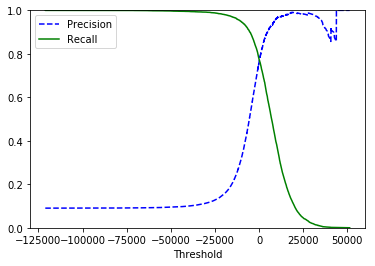

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel('Threshold')
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

根据图像可以很清楚地看出，如果要 recall 达到 90%，那么 threshold 大概需要为 -10000（具体需要仔细计算获得），因此可以将 confidence scores 大于 -10000 的样本的标签设为 1。

In [19]:
y_train_pred_recall_90 = (y_scores > -10000)

{
    'precision': precision_score(y_train_5, y_train_pred_recall_90),
    'recall': recall_score(y_train_5, y_train_pred_recall_90)
}

{'precision': 0.32091511438929865, 'recall': 0.9470577384246449}


precision 和 recall 之间存在权衡，如果要确定两者的对应关系，可以直接以 precisions 和 recalls 为横纵轴，画出两者的变化关系：

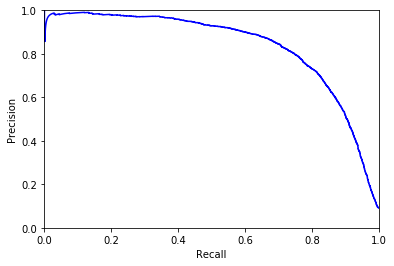

In [20]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", label="Precision")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0, 1])
    plt.ylim([0, 1])

plot_precision_vs_recall(precisions, recalls)

通过这个曲线，可以看出某个 recall 对应的 precision，以此来进行两者的权衡。

### 5. ROC 曲线

ROC (receiveroperating characteristic)，翻译过来为接收者操作特征，说实在的我还不知道这到底是个啥意思。

要想提高召回率，那就尽可能多的样本分类为正例，但这也就会增加 FP（假正例）的量。ROC 曲线能够反映出召回率的上升和错分正例比率的关系。如果这条曲线与纵轴贴的很近，那说明不需要出现太多假正例，就能得到不错的召回率。

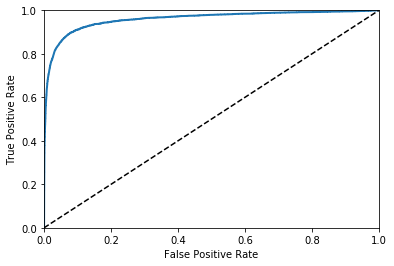

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)

通过观察 ROC 曲线很容易判断分类器的效果，曲线越贴近左上角越好，曲线包围的面积越大越好。ROC 曲线可以观察出分类器对样本的区分程度，如果分类器对所有正样本的评分大于负样本，阈值在由小到大变化的时候，召回率一直为 1，此时 ROC 曲线的面积为 1。如果分类器乱猜一气，那么猜对的和猜错的几乎对半分，此时 ROC 曲线就是上图中 45° 的虚线那样。


使用 `roc_auc_score` 能计算出曲线下面积（AUC, area under the curve）。

In [22]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9596933795449549

为了比较不同分类器的效果，这里训练一个 `RandomForestClassifier` 分类器，来与 SGD 对比。

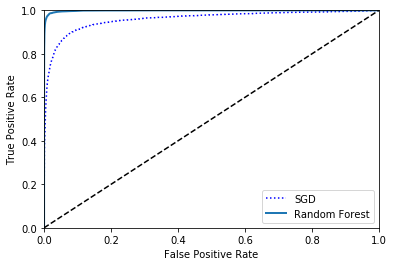

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=5, method='predict_proba', n_jobs=-1)

y_scores_forest = y_probas_forest[:,1]
fpr_forset, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

# SGD 的 ROC 曲线
plt.plot(fpr, tpr, "b:", label='SGD')

# RandomForest 的 ROC 曲线
plot_roc_curve(fpr_forset, tpr_forest, label="Random Forest",)
plt.legend(loc='lower right')

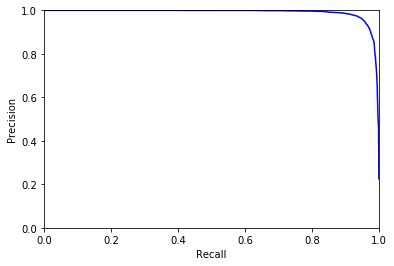

In [24]:
# 观察 RandomForest 的精度和召回率曲线
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

plot_precision_vs_recall(precisions_forest, recalls_forest)

In [25]:
roc_auc_score(y_train_5, y_scores_forest)

0.9986528972746693

可以看到 roc_auc 达到了 99.86%，且 precision 和 recall 曲线更加贴近右上角，分类取得了不错的效果。如果取 recall 为 90%，那么精度也能达到 95% 以上。看来 `RandomForest` 分类器的分类效果较 `SGD` 要好（这很自然）。

## 多分类

多分类任务，可以使用二分类分类器来完成，通过采用 1 对多 或者 1 对 1 的策略训练多个分类器，并将这些分类器组合成一个多分类器。

对于 N 分类任务，如果采用 1 对 1 的策略，需要训练 N(N-1) 个分类器，但是每次训练只在两类样本上进行，训练的速度会更快。而 1 对多，需要训练 N 个分类器，但每次都是在全部样本上来进行的，训练速度常常慢于 1 对 1。

在 Scikit-Learn 中，如果使用二分类分类器来进行多分类，除了 SVM 外，会自动使用 1 对多的策略。如果要强制使用某种策略，可以使用 `OneVsOneClassifier` 或者 `OneVsRestClassifier` 这两个类：

In [26]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=100, tol=0.01))

ovo_clf.fit(X_train, y_train)

len(ovo_clf.estimators_)

45

这里使用 1 对 1 的策略，共训练了 `10*9=45` 个分类器来完成分类任务。对于随机森林分类器，它本身就是多分类分类器，所以无需采用 1 对 1 或者 1 对多 的策略。

In [27]:
forest_clf.fit(X_train, y_train)

(forest_clf.predict_proba([X_train[1]]), y_train[1])

(array([[0.  , 0.  , 0.01, 0.02, 0.  , 0.  , 0.01, 0.  , 0.96, 0.  ]]), 8.0)

在随机森林分类器上调用 `predict_proba` 可以得出某个样本在被分到各个类别上的概率，可以取概率最大的类，将样本分到某一类，也可以取概率最高的前 2 类，将样本分到两个类别中。上面给出的样本是实际是 8 ，而预测结果显示样本为 8 的概率为 96%。

### 对数据做预处理能够提升分类效果

对数据不做任何处理，使用 SGDClassifier 做多分类得到的平均精度大约为 `86%`

In [28]:
cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

array([0.85422741, 0.86885519, 0.85066667, 0.87005085, 0.87762588])

将样本做一些预处理，常常能够很轻易地提升准确率。因为手写数字图片中数字的颜色深浅不同，可将其做标准化后，消除颜色差异的影响。`StandardScaler` 的做法是将样本的各个维度减去均值，然后除以标准差。如此以来样本的所有属性的值都落在了 0~1 之间。

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=5, scoring='accuracy')

array([0.91578509, 0.9095984 , 0.91375   , 0.90947737, 0.91222074])

做了数据预处理后，准确率提升了 4 个百分点。

### 误分类分析

使用 confusion matrix 对多分类器的分类的结果进行分析，可以看出容易分错的样本类型，以及容易被误分到哪一类，由此可采取合理的手段来改进。

confusion_matrix 返回的是一个矩阵，可以将此矩阵传入 matshow 绘制出来，便于直观地观察。

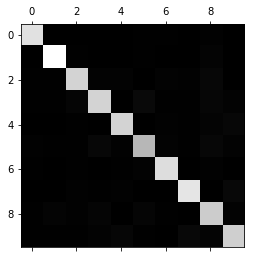

In [31]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=5)

conf_mat = confusion_matrix(y_train, y_train_pred)

plt.matshow(conf_mat, cmap=plt.cm.gray)

从图中可以看到，主对角线上呈亮白色，说明大部分样本都分类正确了。为了观察分类错误的样本，需要让主对角线以外的块能够显示的更明显一些。可取的做法是求出每个块在该行的占比，即某个类别分其他各类的比重，然后将主对角置零，如此以来就能明显地看到错分的情况了。

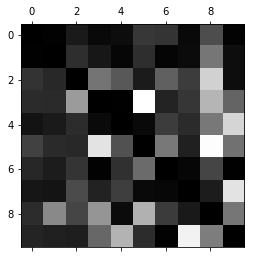

In [32]:
row_sums = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mat = conf_mat / row_sums

np.fill_diagonal(norm_conf_mat, 0)

plt.matshow(norm_conf_mat, cmap=plt.cm.gray)

从上图能够看到 `5->3`, `3->5`, `7->9`, `5->8` 这是几个容易错分的类别组合。

把数字 3 和 5 的图片挑出来一部分，进行观察：

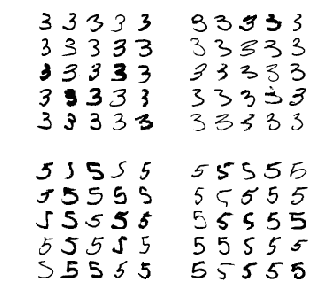

In [33]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]


plt.figure(figsize=(5,5))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

其中副对角线上位为错分的图片，可以看出他们还是有很明显的特征的，但是分错了。这是因为这里采用了很简单的 SGD 分类器，这个分类器就是简单地对各个像素点上的值进行了一个线性加权求和，然后使用梯度下降的方法求合适的权重。这个模型采用的提取特征的方式太简陋，因此面对 3 和 5 这样的在像素点分布差不太多的类别时，就容易出错。

采用其他能够更好地提取特征的模型，可能能够提升分类效果。